In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/processed/dataset_processed.csv")

X = df.iloc[:, :51].drop(columns=['file_path'])
Y = df.iloc[:, 51:]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

In [3]:
print("Dataset shape: ", df.shape)
print(f"✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")

Dataset shape:  (3088, 64)
✓ Training set: (2470, 50)
✓ Test set: (618, 50)


In [4]:
try:
    print("✓ GPU is available and working!")
    xgb_baseline = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', device='cuda')
except Exception as e:
    print("❌ GPU not available")
    print(f"Error: {e}")
    print("→ Falling back to CPU")
    xgb_baseline = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
    
multi_baseline = MultiOutputClassifier(xgb_baseline)
xgb_baseline.fit(X_train, Y_train)
print("✓ XGBoost model trained!")

✓ GPU is available and working!
✓ XGBoost model trained!


In [5]:
y_pred_baseline_train = xgb_baseline.predict(X_train)
y_pred_baseline_test = xgb_baseline.predict(X_test)

In [6]:
train_acc = accuracy_score(Y_train, y_pred_baseline_train)
test_acc = accuracy_score(Y_test, y_pred_baseline_test)

print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

  Training Accuracy: 0.9996
  Test Accuracy: 0.9029


In [7]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

try:
    print("✓ GPU is available and working!")
    xgb_grid = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', device='cuda')
except Exception as e:
    print("❌ GPU not available")
    print(f"Error: {e}")
    print("→ Falling back to CPU")
    xgb_grid = xgb.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')

multi_multi_grid = MultiOutputClassifier(xgb_grid)

✓ GPU is available and working!


In [8]:
grid_search = GridSearchCV(
    estimator=multi_multi_grid,
    param_grid={'estimator__' + key: value for key, value in param_grid.items()},
    scoring='f1_micro',
    cv=3,
    verbose=1,
    n_jobs=1
)

grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


,estimator,"MultiOutputCl...ee=None, ...))"
,param_grid,"{'estimator__colsample_bytree': [0.7, 0.8, ...], 'estimator__gamma': [0, 0.1, ...], 'estimator__learning_rate': [0.1, 0.3], 'estimator__max_depth': [3, 6, ...], ...}"
,scoring,'f1_micro'
,n_jobs,1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [9]:
best_params = {k.replace('estimator__', ''): v for k, v in grid_search.best_params_.items()}
print("Best Parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Best Parameters:
  colsample_bytree: 0.8
  gamma: 0.1
  learning_rate: 0.1
  max_depth: 9
  min_child_weight: 1
  n_estimators: 100
  subsample: 1.0


In [10]:
print("RETRAINING TUNED MODEL")
print("="*60)

try:
    print("✓ GPU is available and working!")
    xgb_final = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1, eval_metric='logloss', device='cuda')
except Exception as e:
    print("❌ GPU not available")
    print(f"Error: {e}")
    print("→ Falling back to CPU")
    xgb_final = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1, eval_metric='logloss')

tuned_model = MultiOutputClassifier(xgb_final)
tuned_model.fit(X_train, Y_train)

RETRAINING TUNED MODEL
✓ GPU is available and working!


,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,'cuda'
,early_stopping_rounds,None


In [11]:
y_pred_tuned_train = tuned_model.predict(X_train)
y_pred_tuned_test = tuned_model.predict(X_test)

In [12]:
train_acc_tuned = accuracy_score(Y_train, y_pred_tuned_train)
test_acc_tuned = accuracy_score(Y_test, y_pred_tuned_test)

print(f"  Training Accuracy: {train_acc_tuned:.4f}")
print(f"  Test Accuracy: {test_acc_tuned:.4f}")

  Training Accuracy: 0.9984
  Test Accuracy: 0.8964


In [13]:
print("Classification Report:")
print("-" * 60)
print(classification_report(Y_test, y_pred_tuned_test, target_names=Y.columns, zero_division=0))

Classification Report:
------------------------------------------------------------
                      precision    recall  f1-score   support

       y_FeatureEnvy       1.00      0.99      0.99       214
  y_FormattingIssues       0.92      0.90      0.91       250
  y_GlobalStateAbuse       1.00      1.00      1.00        36
          y_GodClass       0.86      0.83      0.84        23
y_LargeParameterList       1.00      1.00      1.00       352
         y_LazyClass       1.00      1.00      1.00        95
        y_LongMethod       1.00      1.00      1.00       150
y_MisleadingComments       1.00      1.00      1.00       221
 y_PoorDocumentation       1.00      1.00      1.00       398
     y_SpaghettiCode       1.00      0.76      0.86        21
    y_UnstableModule       1.00      0.94      0.97        16
      y_UntestedCode       1.00      1.00      1.00       226
         y_any_smell       0.99      1.00      0.99       543

           micro avg       0.99      0.98     

Tuned Model Confusion Matrices


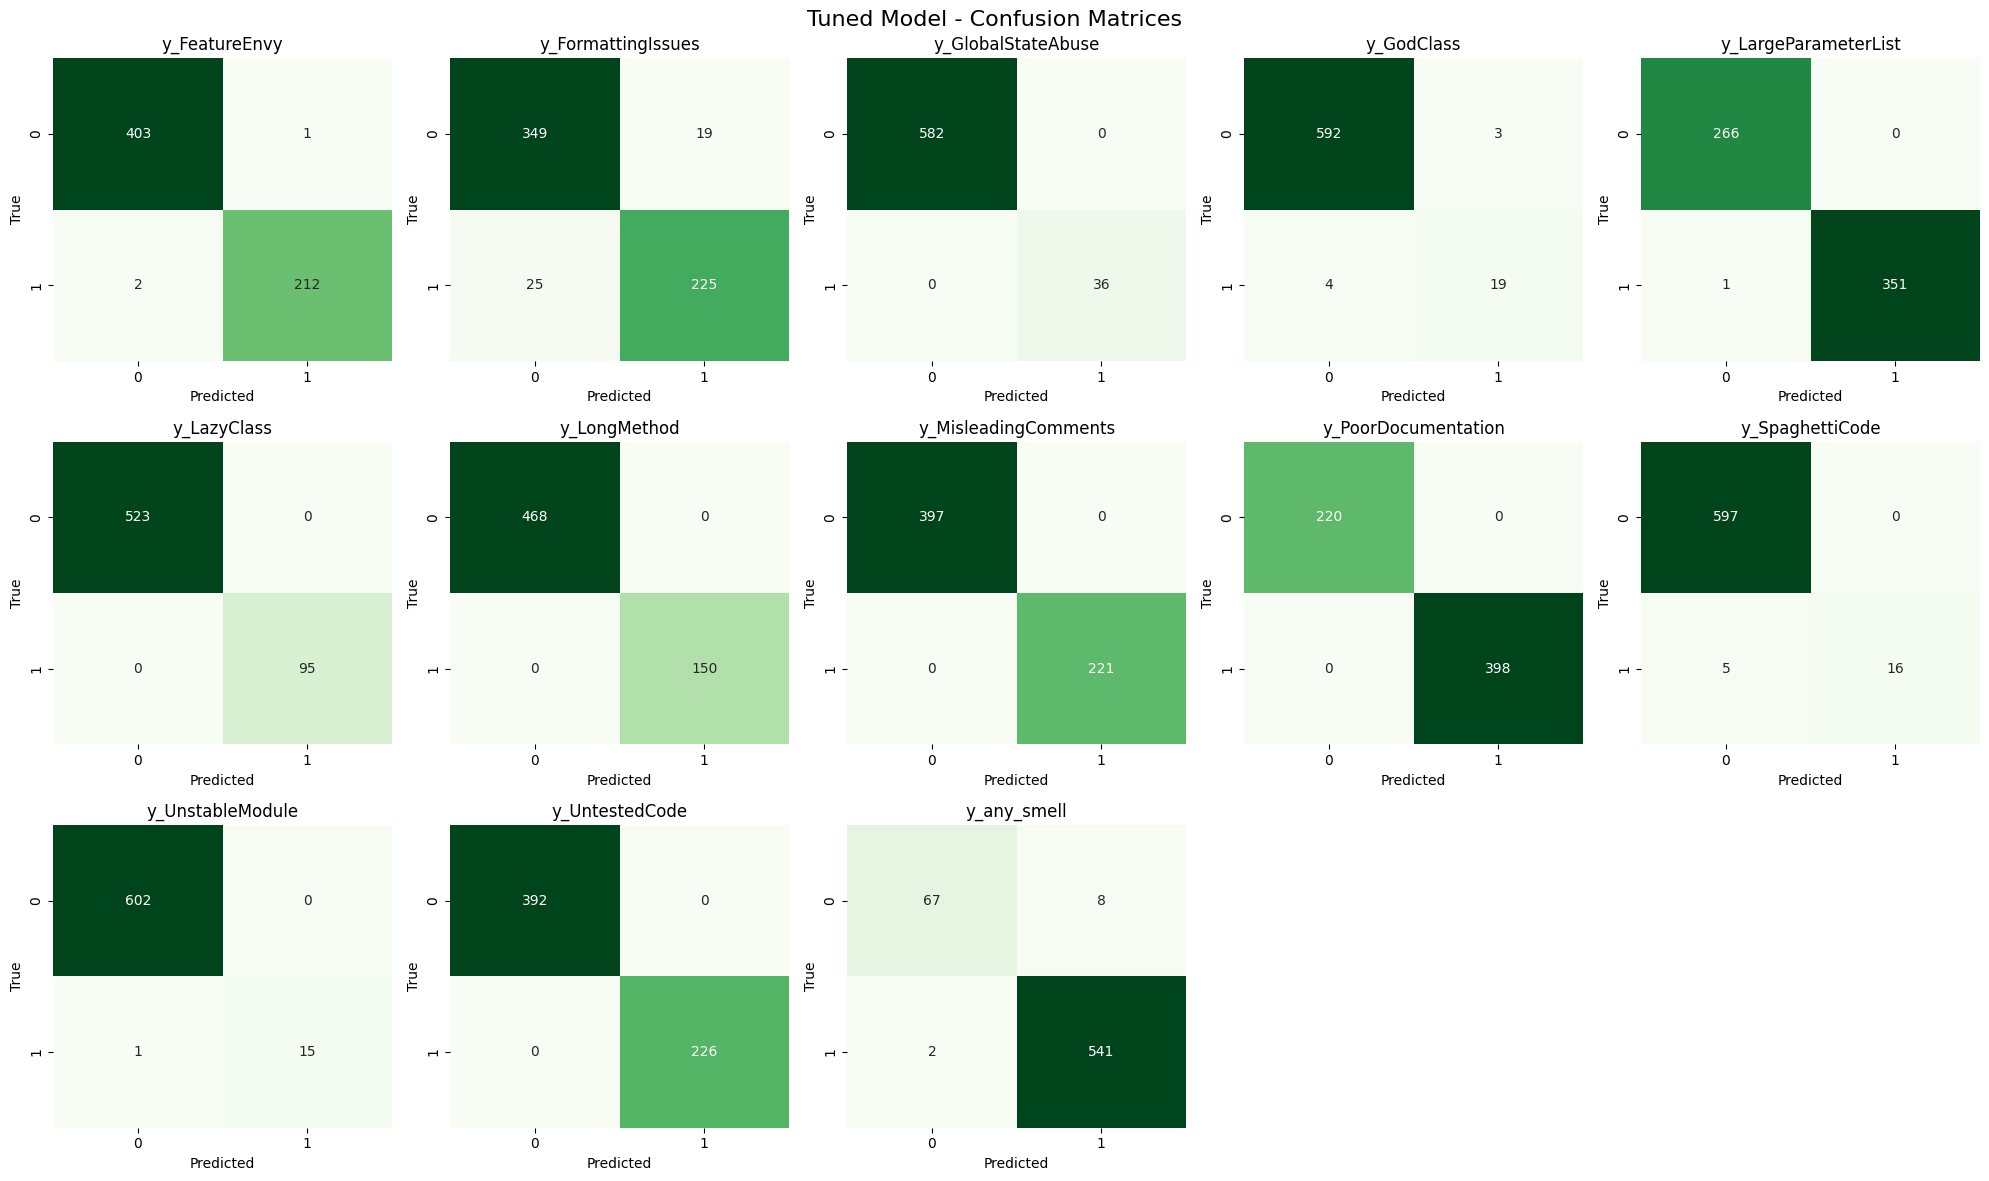

In [ ]:
# Confusion Matrix Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, len(Y.columns), figsize=(5 * len(Y.columns), 4))
if len(Y.columns) == 1:
    axes = [axes]

for i, col in enumerate(Y.columns):
    cm = confusion_matrix(Y_test[col], y_pred_tuned_test[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    axes[i].set_title(col)

plt.tight_layout()
plt.savefig("../models/xgboost_confusion_matrix.png", dpi=150)
plt.show()

In [ ]:
# Cross-Validation Scores Visualization
cv_scores = grid_search.cv_results_["mean_test_score"]
cv_std = grid_search.cv_results_["std_test_score"]

plt.figure(figsize=(10, 5))
x = np.arange(len(cv_scores))
plt.plot(x, cv_scores, marker="o", color="steelblue", linewidth=2, markersize=6)
plt.fill_between(x, cv_scores - cv_std, cv_scores + cv_std, alpha=0.2, color="steelblue")
plt.axhline(y=cv_scores.mean(), color="red", linestyle="--", label=f"Mean: {cv_scores.mean():.3f}")
plt.xlabel("Parameter Combination")
plt.ylabel("CV Score (F1 Micro)")
plt.title("XGBoost - Cross-Validation Scores")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../models/xgboost_cv_scores.png", dpi=150)
plt.show()

\Feature Importance Analysis

Top 15 Most Important Features:
                                feature  importance
external_vs_internal_field_access_ratio    0.416821
                    inter_file_coupling    0.136182
                    test_function_count    0.080757
                              functions    0.054637
                 documentation_coverage    0.030182
                       test_files_found    0.020750
              average_methods_per_class    0.018346
          average_cyclomatic_complexity    0.014256
                          total_imports    0.013100
                  mean_cyclomatic_ratio    0.011843
                mean_lines_per_function    0.010584
                halstead_estimated_bugs    0.010446
                   max_cyclomatic_ratio    0.010389
                     unit_test_presence    0.010028
                       globals_declared    0.009886


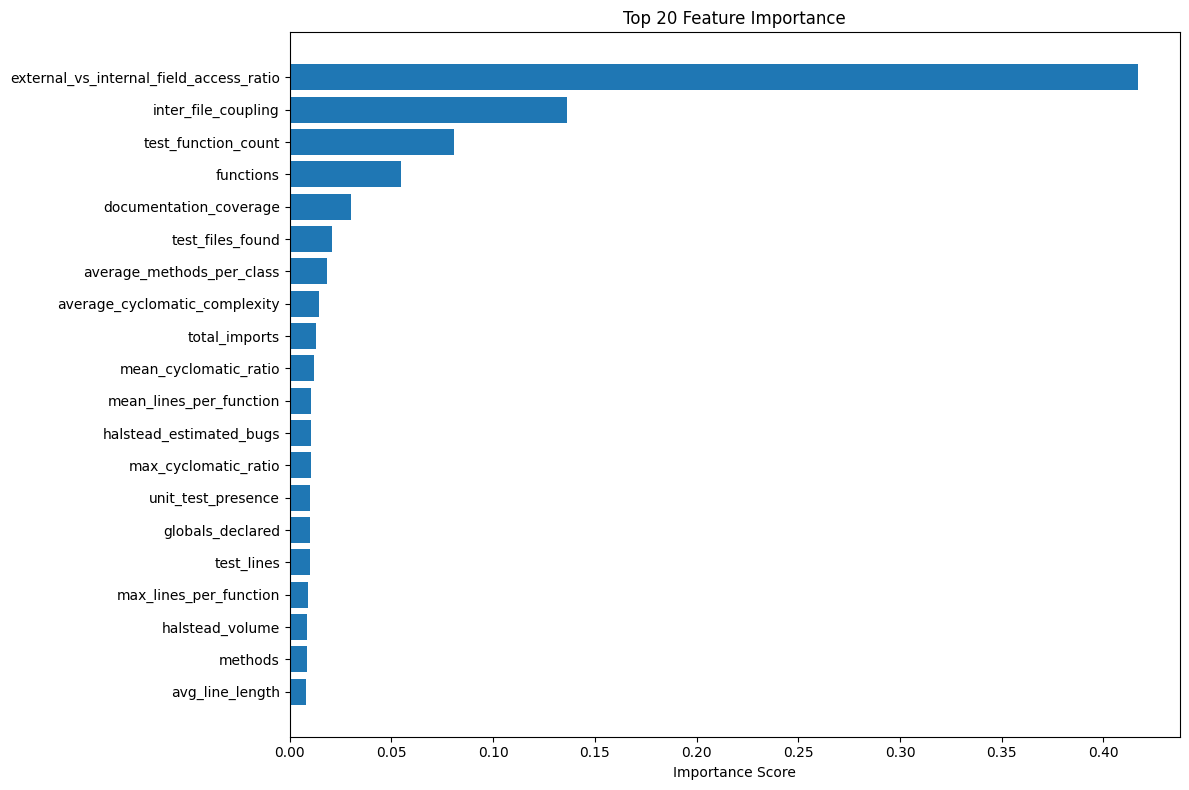

In [15]:
print("\Feature Importance Analysis")

# Extract first estimator from the tuned MultiOutputClassifier
first_estimator = tuned_model.estimators_[0]
importance = first_estimator.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
print("\n[Saving Model]")
with open('../models/xgboost_tuned.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)
    
print("✓ Saved 'xgboost_tuned.pkl' (Ready for future use)")


[Saving Model]
✓ Saved 'dataset_xgboost_tuned.pkl' (Ready for future use)
